In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pyfar as pf
import scipy as sp
import sounddevice as sd
import soundfile as sf
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
def skew(X):
    X = np.triu(X,1)
    return X - X.T

In [ ]:
filepath = 'Params/'

init = False
N = 4 # number of delay lines [4, 8, 16, 32]
delay_set = 1 

filename = 'param'

if init == True:
    filename+='_init'

filename+= '_N'+str(N)+'_d'+str(delay_set)

df = pd.read_csv(filepath+filename+'.csv',
                delimiter=';',
                nrows=N*N,
                dtype={'A':np.float32,'m':'Int32'})

A = df['A'].to_numpy().reshape(N, N)
B = df['B'][:N].to_numpy()
C = df['C'][:N].to_numpy()
delay_lens = df['m'][:N].to_numpy()

B = B[:,np.newaxis]
C = C[np.newaxis,:]


In [55]:
fs = 48_000
t60 = 3.0 
g = 10**(-3/(fs*t60))

ir_len = int(t60*fs)

G = np.diag(g**delay_lens) # Dämpfungsmatrix
A_g = sp.linalg.expm(skew(A)) @ G  # Feedback Matrix mit Dämpfung 

impulse = np.zeros((ir_len, C.shape[0]))
impulse[0, :] = 1

output = np.zeros((ir_len, 1))

# Delayline-Puffer (Liste von N Arrays)
delay_lines = [
    np.zeros(delay_lens[i]) for i in range(N)
]

# Pointer zum Lesen und Schreiben
write_ptr = np.zeros(N, dtype=int)
read_ptr = np.zeros(N, dtype=int)

for n in range(ir_len):

    # 1) Delay-Ausgänge lesen
    d = np.zeros((N,1))
    for i in range(N):
        d[i,0] = delay_lines[i][read_ptr[i]]

    # 2) Output berechnen   (y = C * d)
    output[n,0] = (C @ d)[0,0]

    # 3) Eingang berechnen   (u = impulse[n])
    u = impulse[n,0]

    # 4) Feedback berechnen  (A * d  +  B * u)
    next_input = A_g @ d + B * u

    # 5) Werte in Delaylines schreiben
    for i in range(N):
        delay_lines[i][write_ptr[i]] = next_input[i,0]

    # 6) Pointer weiterschieben
    for i in range(N):
        write_ptr[i] = (write_ptr[i] + 1) % delay_lens[i]
        read_ptr[i]  = (read_ptr[i] + 1) % delay_lens[i]


In [23]:
class FeedbackDelay:
    def __init__(self,max_block_size,delays):
        self.delays = delays 
        self.N = len(delays)
        self.values = np.zeros((np.max(delays)+max_block_size,self.N))
        self.pointers = np.zeros(self.N,dtype=int)
    
    def getIndex(self,blk_size):

        row_idx = self.pointers + np.arange(blk_size)[:, None]
        # wrap around when  row_idx > delay line length 
        row_idx = row_idx % self.delays 

        col_idx = np.arange(self.N)[None, :] 
        
        return row_idx,col_idx
    
    def getValues(self,blockSize):
        return self.values[self.getIndex(blockSize)]
        
    # def mod_delay(self,idxs):
    #     idxs = idxs - (idxs > self.delays) * self.delays
    #     return idxs
    
    def setValues(self,val):
        blk_size = val.shape[0]
        self.values[self.getIndex(blk_size)] = val
    
    def next(self,blockSize): # Pointer weiterschieben Ring Buffer 
        self.pointers = (self.pointers + blockSize) % self.delays
        

In [ ]:
def compute_FDN_blk(input,delays,feedbackMatrix,inputGains,outputGains):

    maxBlockSize = 2**12
    blk_size = min([min(delays), maxBlockSize])

    DelayFilters = FeedbackDelay(maxBlockSize,delays)

    input_len = input.shape[0]
    output = np.zeros((input_len,outputGains.shape[0]))

    blk_start = 0

    while blk_start < input_len:
        if(blk_start + blk_size < input_len):
            blk_pos = np.arange(blk_start,blk_start+blk_size)
        else: # last block 
            blk_pos = np.arange(blk_start,input_len-blk_size)

        blk = input[blk_pos,:]

        if blk.shape[0] == 0:
            break

        # ... process block ...
        delay_output = DelayFilters.getValues(blk_size)

        feedback = delay_output @ feedbackMatrix.T

        delay_line_input = blk @ inputGains.T + feedback

        DelayFilters.setValues(delay_line_input)

        output[blk_pos, :] = delay_output @ outputGains.T

        DelayFilters.next(blk_size)

        blk_start += blk_size

    return output


In [63]:
ir_block = compute_FDN_blk(impulse,delay_lens,A_g,B,C)

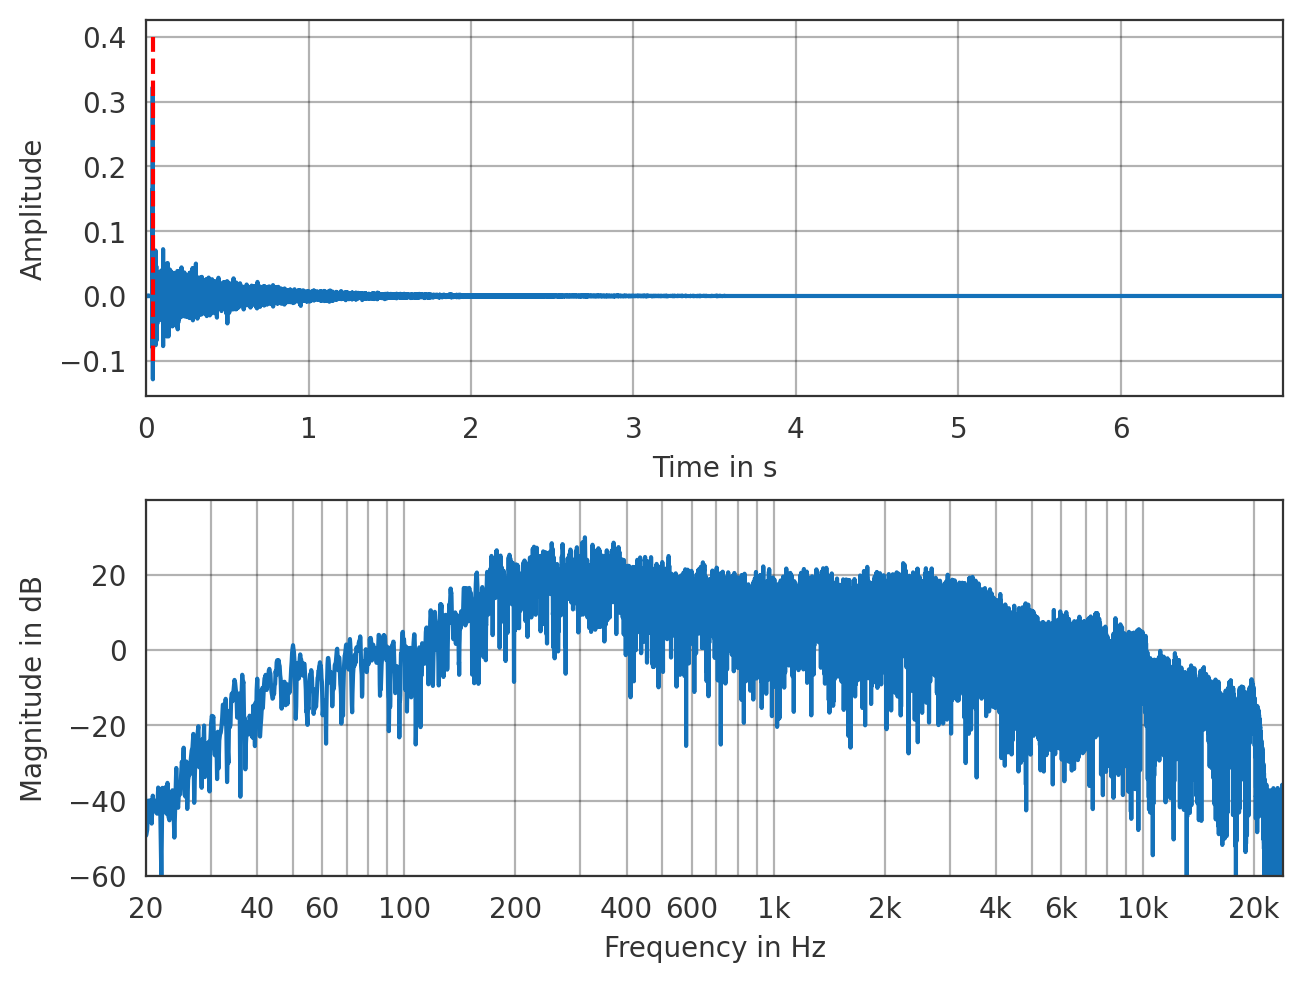

In [5]:

filepath_ir = 'Impulse_Responses/Church_IR/OMNI/'
filename_ir = 'SC_MC_OMNI_'

num = 5

filename_ir += str(num)+'.wav'

ir = sf.read(filepath_ir+filename_ir)

times = np.zeros(len(ir[0]))

for i in range(len(ir[0])):
    times[i] = i/fs


ir_target = pf.Signal([ir[0],times.flatten()],sampling_rate=fs)

start = pf.dsp.find_impulse_response_start(ir_target[0])[0]

pf.plot.use()
plt.figure()
ax = pf.plot.time_freq(ir_target[0])
ax[0].vlines(x=start/fs,ymin=-0.1,ymax=0.4,linestyles='--',colors='red')
plt.show()


In [151]:
sd.play(ir_target.time.T[:fs*3],samplerate=fs,blocking=True) 

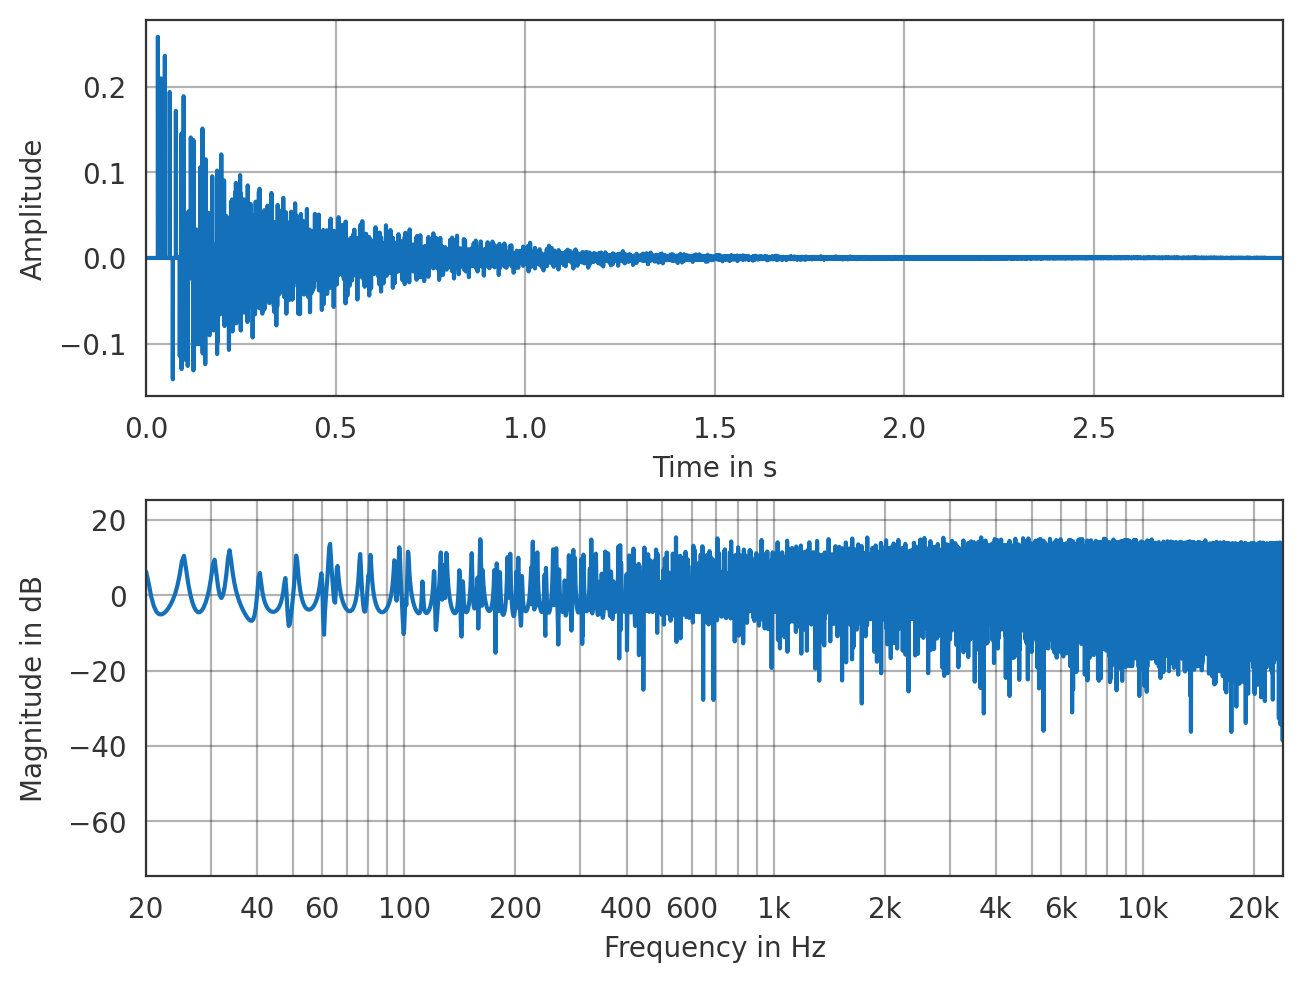

KeyboardInterrupt: 

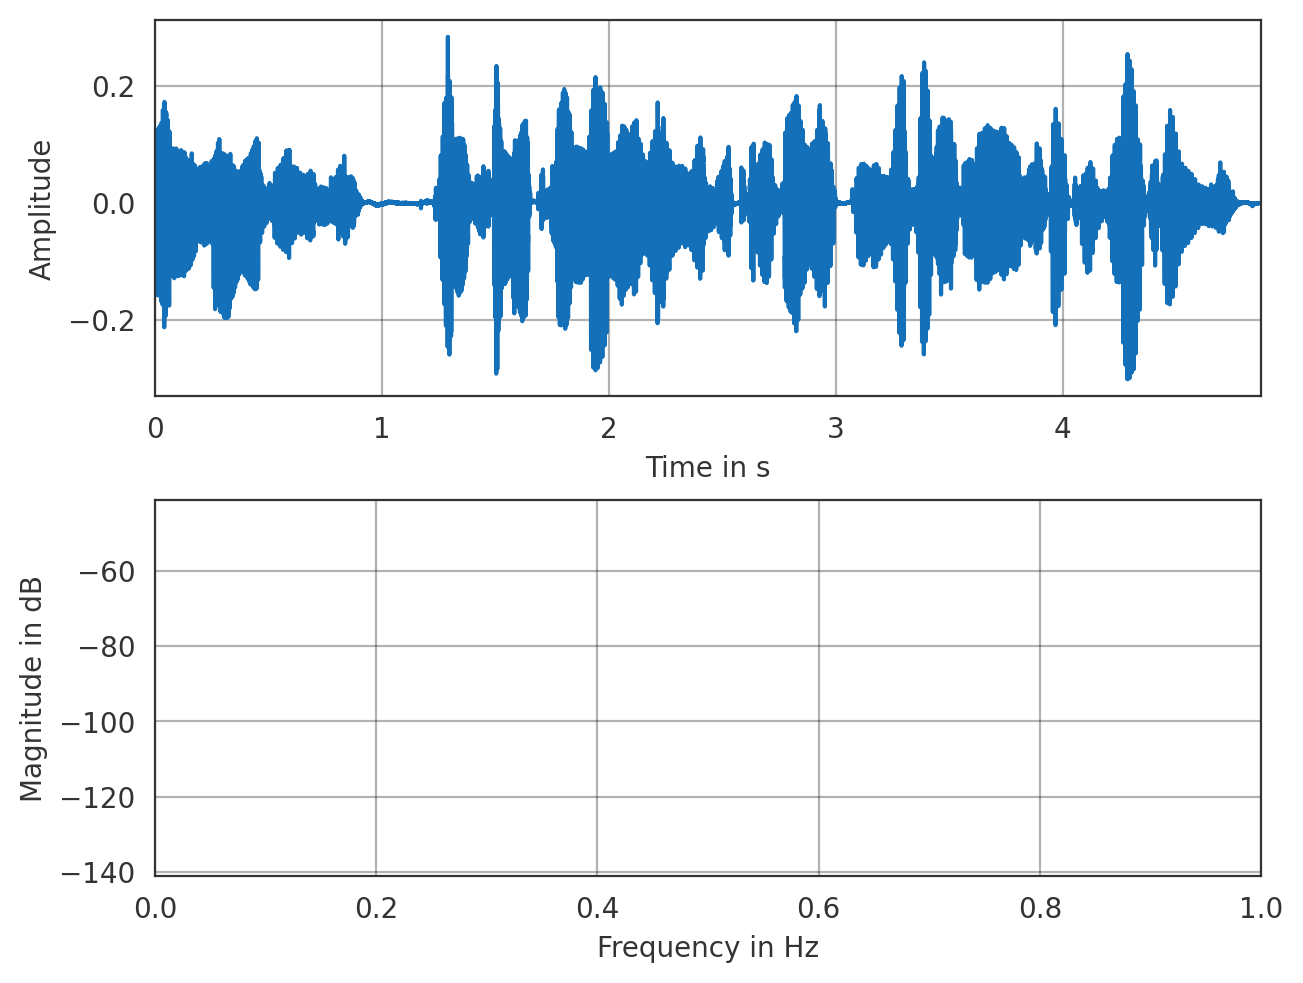

In [56]:
times = np.zeros(len(output))

for i in range(len(output)):
    times[i] = i/fs

ir_gen = pf.Signal([output.flatten(),times.flatten()],sampling_rate=fs)

pf.plot.use()
plt.figure()
pf.plot.time_freq(ir_gen[0])
plt.show()

speech = pf.signals.files.speech(voice='male',sampling_rate=fs)

plt.figure()
pf.plot.time_freq(speech)
plt.show()

convolved = pf.dsp.convolve(ir_gen[0],speech)

plt.figure()
pf.plot.time_freq(convolved)
plt.show()


In [167]:
# Play the Impulse Response
sd.play(ir_gen[0].time.T,samplerate=fs) 

In [168]:
# Play male voice convolved with the Impulse Response
sd.play(convolved.time.T,samplerate=fs) 

In [40]:
# write the Impulse Response to .wav file
sf.write(filename+'_impulse.wav',ir_gen[0].time.T,samplerate=fs)

# write male voice convolved with the Impulse Response to .wav file
sf.write(filename+'_convolved.wav',convolved.time.T,samplerate=fs)